### Upload Network Data


In [1]:
import pandas as pd

# Cargar el archivo Excel
df = pd.read_excel("Network.xlsx", sheet_name="Sheet1")  # Ajusta el nombre de la hoja

### Origin Subnetworks

In [2]:
import networkx as nx
import pandas as pd

# --- Interaction type translation (UNCHANGED) ---
interaction_translation = {
    "ALELOPATÍA": "allelopathy",
    "DEPREDACIÓN": "predation",
    "DISPERSIÓN": "dispersal",
    "EPIBIOSIS": "epibiosis",
    "HEMATOFAGIA": "hematophagy",
    "HERBIVORÍA": "herbivory",
    "MUTUALISMO": "mutualism",
    "NIDIFICACIÓN": "nesting",
    "OTRAS INTERACCIONES": "other interactions",
    "OVIPOSICIÓN": "oviposition",
    "PARASITISMO": "parasitism",
    "VISITA FLORAL": "floral visit"
}

# --- Origin mapping (UNCHANGED) ---
def map_origin_real(value):
    if pd.isna(value):
        return "u"
    value = value.strip().lower()
    if value == "nativa":
        return "i"
    if value == "no nativa":
        return "n"
    return "u"

# --- Initialize graphs (UNCHANGED) ---
graphs = {
    "ii": nx.DiGraph(),
    "in": nx.DiGraph(),
    "ix": nx.DiGraph(),
    "ni": nx.DiGraph(),
    "nn": nx.DiGraph(),
    "nx": nx.DiGraph(),
    "xi": nx.DiGraph(),
    "xn": nx.DiGraph(),
    "xx": nx.DiGraph(),
}

# --- Global node attributes ---
node_origin = {}
node_kingdom = {}

# --- Construction (STRUCTURE UNCHANGED) ---
for _, row in df.iterrows():
    taxon1 = row["Taxón 1"]
    taxon2 = row["Taxón 2"]

    o1 = map_origin_real(row["Origen taxón 1"])
    o2 = map_origin_real(row["Origen taxón 2"])

    k1 = row["Reino 1"]
    k2 = row["Reino 2"]

    interaction_es = row["Título de interacción"]
    interaction_en = interaction_translation.get(interaction_es, "unknown")

    # --- Update origin (UNCHANGED) ---
    for taxon, o in [(taxon1, o1), (taxon2, o2)]:
        if taxon not in node_origin:
            node_origin[taxon] = o
        else:
            if "i" in (node_origin[taxon], o):
                node_origin[taxon] = "i"
            elif "n" in (node_origin[taxon], o):
                node_origin[taxon] = "n"

    # --- Store kingdom (PASSIVE, no logic) ---
    if taxon1 not in node_kingdom and pd.notna(k1):
        node_kingdom[taxon1] = k1
    if taxon2 not in node_kingdom and pd.notna(k2):
        node_kingdom[taxon2] = k2

    # --- Add edges (UNCHANGED) ---
    for key, G in graphs.items():
        k1g, k2g = key[0], key[1]

        cond1 = (k1g == "x") or (k1g == o1)
        cond2 = (k2g == "x") or (k2g == o2)

        if cond1 and cond2:
            G.add_edge(
                taxon1,
                taxon2,
                interaction=interaction_en,
                interaction_es=interaction_es
            )

# --- Assign node attributes (POST-HOC ONLY) ---
for G in graphs.values():
    for n in G.nodes():
        G.nodes[n]["origin"] = node_origin.get(n, "u")
        G.nodes[n]["kingdom"] = node_kingdom.get(n, "Unknown")

# --- Expose graphs ---
G_ii = graphs["ii"]
G_in = graphs["in"]
G_ix = graphs["ix"]
G_ni = graphs["ni"]
G_nn = graphs["nn"]
G_nx = graphs["nx"]
G_xi = graphs["xi"]
G_xn = graphs["xn"]
G_xx = graphs["xx"]


### Indigenous vs Non Indigenous Species Pie Chart

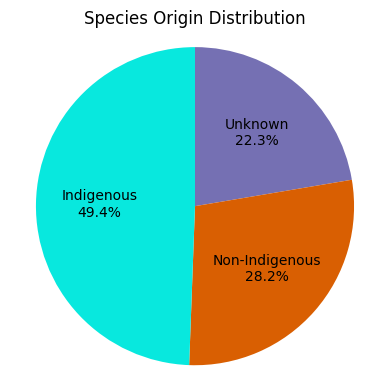

In [3]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_origin_piechart(G, title=None):
    """
    Pie chart with labels INSIDE the pie:
    Label
    Percentage
    """

    origin_map = {
        "i": "Indigenous",
        "n": "Non-Indigenous",
        "u": "Unknown",
        None: "Unknown"
    }

    color_map = {
        "Indigenous": "#08e8de",
        "Non-Indigenous": "#d95f02",
        "Unknown": "#7570b3"
    }

    origins = [
        origin_map.get(G.nodes[n].get("origin"), "Unknown")
        for n in G.nodes
    ]

    counts = Counter(origins)

    labels = list(counts.keys())
    sizes = list(counts.values())
    total = sum(sizes)

    combined_labels = [
        f"{label}\n{100 * size / total:.1f}%"
        for label, size in zip(labels, sizes)
    ]

    colors = [color_map[label] for label in labels]

    fig, ax = plt.subplots(figsize=(4, 4))

    wedges, texts = ax.pie(
        sizes,
        labels=combined_labels,
        colors=colors,
        startangle=90,
        counterclock=False,
        labeldistance=0.6
    )

    for text in texts:
        text.set_fontsize(10)
        text.set_ha("center")
        text.set_va("center")

    ax.set_title(
        title if title is not None
        else "Species Origin Distribution"
    )

    ax.axis("equal")
    plt.tight_layout()
    #plt.savefig('OriginPieChart.png')
    plt.show()


# Example
plot_origin_piechart(G_xx, title="Species Origin Distribution")


### Type of interactions Distributions

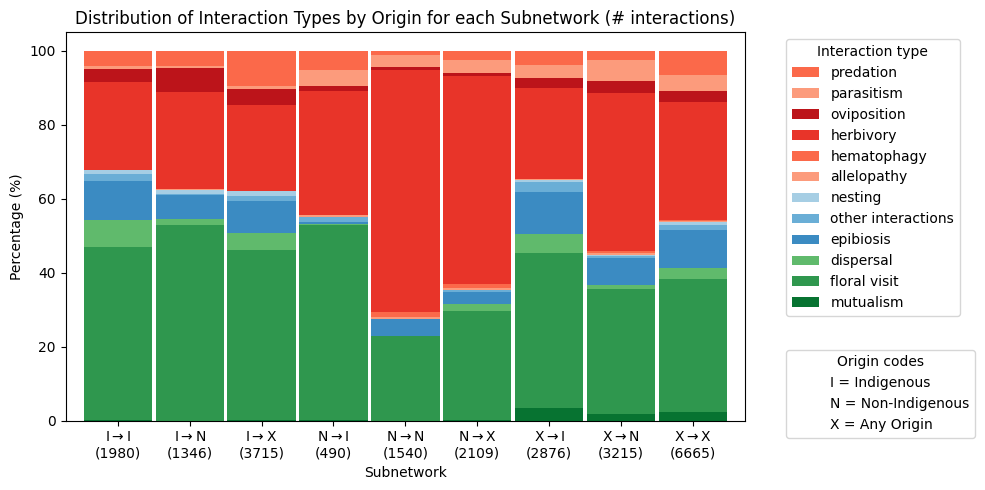

In [4]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Patch

# --- Diccionario de subgrafos ---
subgraphs = {
    "I→I": G_ii,
    "I→N": G_in,
    "I→X": G_ix,
    "N→I": G_ni,
    "N→N": G_nn,
    "N→X": G_nx,
    "X→I": G_xi,
    "X→N": G_xn,
    "X→X": G_xx,
}

# --- Orden deseado del stack (bottom → top) ---
ordered_interactions = [
    "mutualism",
    "floral visit",
    "dispersal",
    "epibiosis",
    "other interactions",
    "nesting",
]

# --- Recolectar todas las interacciones ---
all_interactions = set()
for G in subgraphs.values():
    for _, _, data in G.edges(data=True):
        all_interactions.add(data["interaction"])

# --- No mutualistas ---
non_mutualistic = sorted(
    i for i in all_interactions if i not in ordered_interactions
)

final_order = ordered_interactions + non_mutualistic

# --- DataFrame ---
freq_abs = pd.DataFrame(0, index=subgraphs.keys(), columns=final_order)

for name, G in subgraphs.items():
    for _, _, data in G.edges(data=True):
        freq_abs.loc[name, data["interaction"]] += 1

freq_rel = freq_abs.div(freq_abs.sum(axis=1), axis=0).fillna(0) * 100

# --- Colores ---
greens = cm.Greens([0.85, 0.7, 0.55])
blues = cm.Blues([0.65, 0.5, 0.35])
reds = cm.Reds([0.35, 0.5, 0.65, 0.8])

color_map = {
    "mutualism": greens[0],
    "floral visit": greens[1],
    "dispersal": greens[2],
    "epibiosis": blues[0],
    "other interactions": blues[1],
    "nesting": blues[2],
}

for i, interaction in enumerate(non_mutualistic):
    color_map[interaction] = reds[i % len(reds)]

colors = [color_map[i] for i in final_order]

# --- xticks ---
xtick_labels = []
for name, G in subgraphs.items():
    src, tgt = name.split("→")
    xtick_labels.append(
        rf"$\mathrm{{{src}}}\to\mathrm{{{tgt}}}$" + "\n" + f"({G.number_of_edges()})"
    )

# --- FIGURA (esto SÍ funciona) ---
fig, ax = plt.subplots(figsize=(10, 5))

freq_rel.plot(
    kind="bar",
    stacked=True,
    color=colors,
    width=0.95,
    ax=ax
)

ax.set_xticklabels(xtick_labels, rotation=0)
ax.set_ylabel("Percentage (%)")
ax.set_xlabel("Subnetwork")
ax.set_title("Distribution of Interaction Types by Origin for each Subnetwork (# interactions)")

# --- Leyenda principal (invertida) ---
handles, labels = ax.get_legend_handles_labels()
interaction_legend = ax.legend(
    handles[::-1],
    labels[::-1],
    title="Interaction type",
    bbox_to_anchor=(1.05, 1),
    loc="upper left"
)

# --- Leyenda secundaria ---
origin_legend = ax.legend(
    handles=[
        Patch(facecolor="none", label="I = Indigenous"),
        Patch(facecolor="none", label="N = Non-Indigenous"),
        Patch(facecolor="none", label="X = Any Origin"),
    ],
    title="Origin codes",
    bbox_to_anchor=(1.05, 0.20),
    loc="upper left",
    frameon=True
)

ax.add_artist(interaction_legend)

plt.tight_layout()
#plt.savefig('InteractionType.png')
plt.show()


### Centrality Distributions

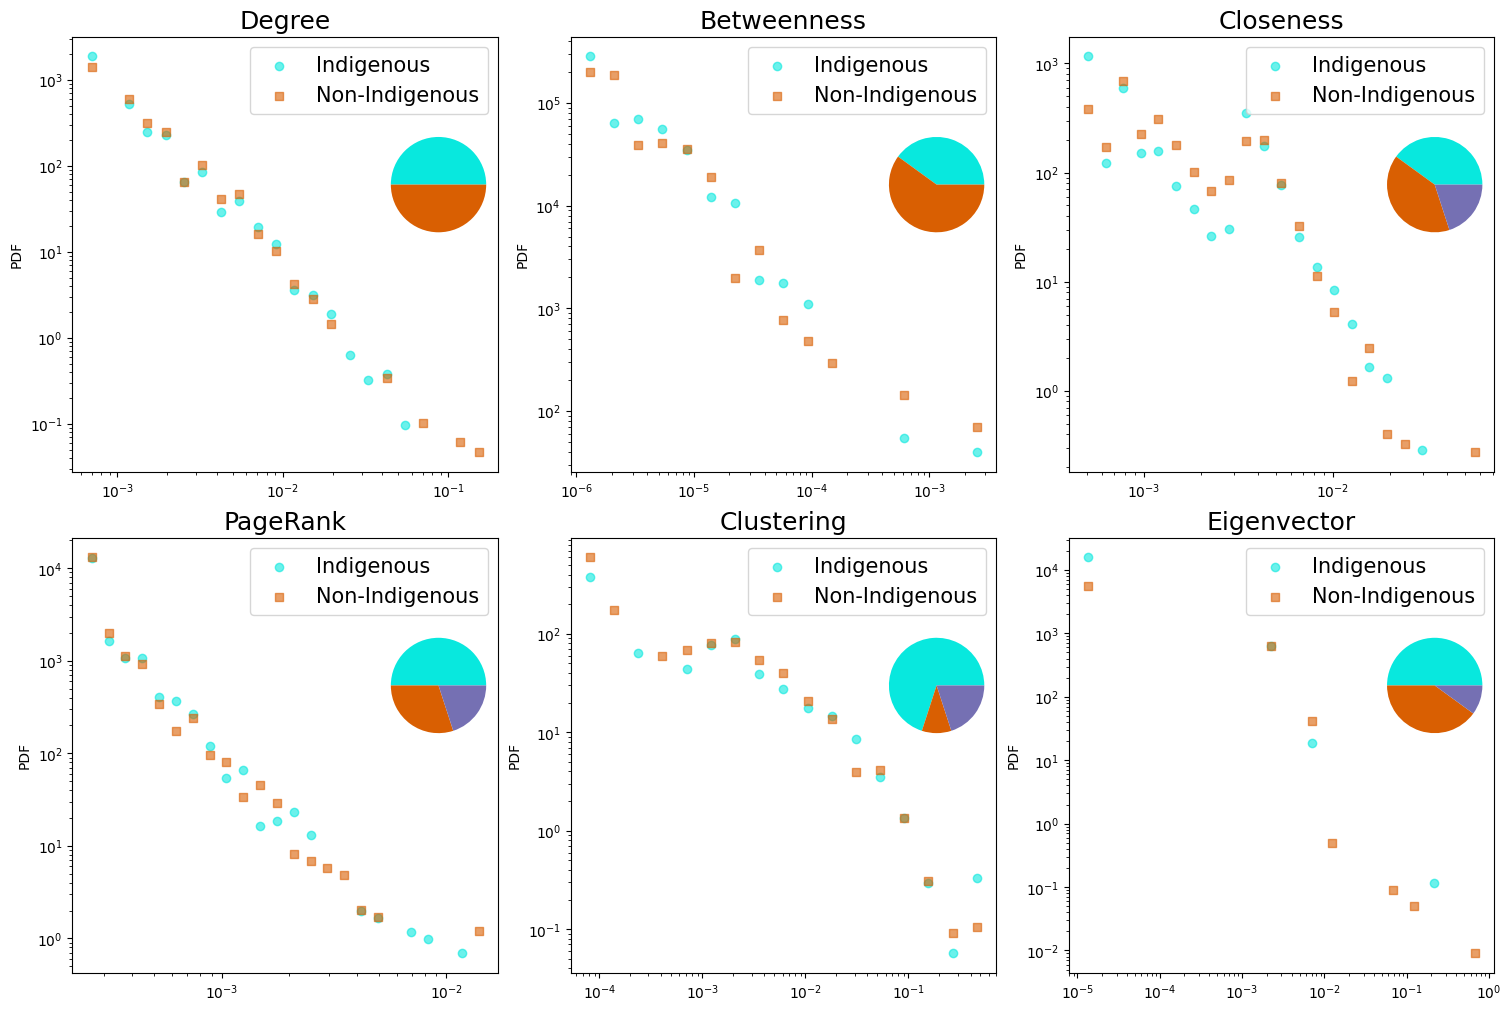

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def plot_centrality_distributions_by_origin(
    G,
    min_value=1e-6,
    max_bins=25,
    normalize=False,
    colors=None,
    top=10
):

    if colors is None:
        colors = {
            "Indigenous": "tab:green",
            "Non-Indigenous": "tab:red",
            "Unknown": "tab:gray"
        }

    metricas_centralidad = {
        'Degree': nx.degree_centrality,
        'Betweenness': nx.betweenness_centrality,
        'Closeness': nx.closeness_centrality,
        'PageRank': nx.pagerank,
        'Clustering': nx.clustering,
        'Eigenvector': lambda g: nx.eigenvector_centrality(
            g, max_iter=1000, tol=1e-6
        )
    }

    fig, axes = plt.subplots(
        2, 3,
        figsize=(15, 10),
        constrained_layout=True
    )
    axes = axes.flatten()

    for ax, (name, func) in zip(axes, metricas_centralidad.items()):

        try:
            values = func(G)
        except Exception:
            ax.set_title(f"{name} (failed)")
            continue

        # ---------- Top origin counts ----------
        sorted_vals = sorted(
            values.items(),
            key=lambda x: x[1],
            reverse=True
        )[:top]

        origin_counts = {"Indigenous": 0, "Non-Indigenous": 0, "Unknown": 0}

        for node, _ in sorted_vals:
            o = G.nodes[node].get("origin", "u")
            if o == "i":
                origin_counts["Indigenous"] += 1
            elif o == "n":
                origin_counts["Non-Indigenous"] += 1
            else:
                origin_counts["Unknown"] += 1

        # ---------- Distributions ----------
        vals_i, vals_n = [], []

        for node, val in values.items():
            o = G.nodes[node].get("origin")
            if val > 0:
                if o == "i":
                    vals_i.append(val)
                elif o == "n":
                    vals_n.append(val)

        if len(vals_i) < 2 and len(vals_n) < 2:
            ax.set_title(f"{name} (insufficient data)")
            continue

        all_vals = np.array(vals_i + vals_n)
        n_bins = min(max_bins, int(np.sqrt(len(all_vals))) + 5)

        vmin = max(min_value, all_vals.min())
        vmax = 1.0 if name == "Clustering" else all_vals.max()
        bins = np.logspace(np.log10(vmin), np.log10(vmax), n_bins)

        def plot_points(data, label, marker):
            counts, edges = np.histogram(data, bins=bins, density=True)
            centers = edges[:-1] + np.diff(edges) / 2
            mask = counts > 0
            ax.scatter(
                centers[mask],
                counts[mask],
                marker=marker,
                color=colors[label],
                alpha=0.6,
                label=label
            )

        if len(vals_i) >= 2:
            plot_points(vals_i, "Indigenous", "o")
        if len(vals_n) >= 2:
            plot_points(vals_n, "Non-Indigenous", "s")

        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_ylabel("PDF")
        ax.set_title(name, fontsize=18)
        ax.legend(loc="upper right", fontsize=15)
        ax.grid(False)

        # ---------- Minimal inset pie ----------
        pie_ax = inset_axes(
            ax,
            width="28%",
            height="28%",
            loc="upper right",
            bbox_to_anchor=(0, -0.2, 1, 1),
            bbox_transform=ax.transAxes,
            borderpad=0
        )

        sizes = []
        pie_colors = []

        for k in ["Indigenous", "Non-Indigenous", "Unknown"]:
            if origin_counts[k] > 0:
                sizes.append(origin_counts[k])
                pie_colors.append(colors[k])

        pie_ax.pie(
            sizes,
            colors=pie_colors,
            wedgeprops=dict(linewidth=0)
        )
        pie_ax.axis("off")

    #plt.suptitle(f"Centrality Distributions by Origin | Top {top} Pie Chart", fontsize=14)
    plt.savefig('CentralityMeasures.png')
    plt.show()

plot_centrality_distributions_by_origin(
    G_xx,
    colors={
        "Indigenous": "#08e8de",
        "Non-Indigenous": "#d95f02",
        "Unknown": "#7570b3"
    },
    top=10
)

### Inter-Kingdom Nestedness and Modularity

In [6]:
import itertools
import networkx as nx

def build_kingdom_pair_and_interaction_subnetworks(G_xx):

    # -----------------------------
    # Normalización de reinos
    # -----------------------------
    def normalize_kingdom(k):
        if k == "Protozoa":
            return "Chromista"
        return k

    # Reinos presentes
    kingdoms = set(
        normalize_kingdom(G_xx.nodes[n].get("kingdom"))
        for n in G_xx.nodes
        if G_xx.nodes[n].get("kingdom") is not None
    )

    # Abreviaturas
    abbrev = {
        "Animalia": "a",
        "Plantae": "p",
        "Bacteria": "b",
        "Fungi": "f",
        "Chromista": "c"
    }

    # Tipos de interacción
    mutualistic_types = {"mutualism", "floral visit", "dispersal"}
    parasitic_types = {"parasitism"}

    subnetworks = {}

    # -----------------------------
    # Subredes por pares de reinos
    # -----------------------------
    for k1, k2 in itertools.combinations(sorted(kingdoms), 2):

        if k1 not in abbrev or k2 not in abbrev:
            continue

        base_name = f"G_{abbrev[k1]}{abbrev[k2]}"
        G_pair = nx.Graph()

        for u, v, data in G_xx.edges(data=True):
            ku = normalize_kingdom(G_xx.nodes[u].get("kingdom"))
            kv = normalize_kingdom(G_xx.nodes[v].get("kingdom"))

            if {ku, kv} == {k1, k2}:
                G_pair.add_node(u, **G_xx.nodes[u])
                G_pair.add_node(v, **G_xx.nodes[v])
                G_pair.add_edge(u, v, **data)

        subnetworks[base_name] = G_pair

        # -----------------------------
        # Subsubred mutualista
        # -----------------------------
        G_m = nx.Graph()
        for u, v, data in G_pair.edges(data=True):
            if data.get("interaction") in mutualistic_types:
                G_m.add_node(u, **G_pair.nodes[u])
                G_m.add_node(v, **G_pair.nodes[v])
                G_m.add_edge(u, v, **data)

        subnetworks[f"{base_name}_m"] = G_m

        # -----------------------------
        # Subsubred parasitismo
        # -----------------------------
        G_p = nx.Graph()
        for u, v, data in G_pair.edges(data=True):
            if data.get("interaction") in parasitic_types:
                G_p.add_node(u, **G_pair.nodes[u])
                G_p.add_node(v, **G_pair.nodes[v])
                G_p.add_edge(u, v, **data)

        subnetworks[f"{base_name}_p"] = G_p

    # -----------------------------
    # Impresión de resultados
    # -----------------------------
    print("Subnetworks per kingdom:\n")
    for name, G in sorted(subnetworks.items()):
        print(
            f"{name}: "
            f"{G.number_of_nodes()} nodes, "
            f"{G.number_of_edges()} edges"
        )

    return subnetworks


subredes = build_kingdom_pair_and_interaction_subnetworks(G_xx)


Subnetworks per kingdom:

G_ab: 47 nodes, 46 edges
G_ab_m: 29 nodes, 31 edges
G_ab_p: 12 nodes, 8 edges
G_ac: 36 nodes, 30 edges
G_ac_m: 6 nodes, 5 edges
G_ac_p: 30 nodes, 25 edges
G_af: 25 nodes, 19 edges
G_af_m: 6 nodes, 5 edges
G_af_p: 13 nodes, 9 edges
G_ap: 1799 nodes, 4886 edges
G_ap_m: 1037 nodes, 2501 edges
G_ap_p: 8 nodes, 6 edges
G_bc: 0 nodes, 0 edges
G_bc_m: 0 nodes, 0 edges
G_bc_p: 0 nodes, 0 edges
G_bf: 6 nodes, 5 edges
G_bf_m: 0 nodes, 0 edges
G_bf_p: 0 nodes, 0 edges
G_bp: 55 nodes, 57 edges
G_bp_m: 25 nodes, 26 edges
G_bp_p: 30 nodes, 26 edges
G_cf: 0 nodes, 0 edges
G_cf_m: 0 nodes, 0 edges
G_cf_p: 0 nodes, 0 edges
G_cp: 34 nodes, 32 edges
G_cp_m: 0 nodes, 0 edges
G_cp_p: 30 nodes, 29 edges
G_fp: 404 nodes, 544 edges
G_fp_m: 81 nodes, 119 edges
G_fp_p: 137 nodes, 109 edges


In [7]:
import numpy as np
import networkx as nx
from tabulate import tabulate
from networkx.algorithms.community import greedy_modularity_communities

# ---------------------------------------------------
# Classical NODF implementation (exact definition)
# ---------------------------------------------------
def compute_nodf_bipartite(G):
    """
    Classical NODF implementation.
    Allows Chromista + Protozoa to be treated as a single functional group.
    """

    # --- Functional kingdom mapping (ONLY for NODF) ---
    def map_kingdom(k):
        if k in ("Chromista", "Protozoa"):
            return "Chromista+Protozoa"
        return k

    # --- Separate nodes by functional kingdom ---
    kingdom_groups = {}
    for n in G.nodes:
        k = G.nodes[n].get("kingdom")
        if k is None:
            continue
        kf = map_kingdom(k)
        kingdom_groups.setdefault(kf, set()).add(n)

    if len(kingdom_groups) != 2:
        return np.nan  # Still not bipartite

    group1, group2 = list(kingdom_groups.values())

    if len(group1) < 2 or len(group2) < 2:
        return np.nan

    group1 = list(group1)
    group2 = list(group2)

    idx1 = {n: i for i, n in enumerate(group1)}
    idx2 = {n: i for i, n in enumerate(group2)}

    # --- Build binary incidence matrix ---
    M = np.zeros((len(group1), len(group2)), dtype=int)

    for u, v in G.edges():
        ku = map_kingdom(G.nodes[u].get("kingdom"))
        kv = map_kingdom(G.nodes[v].get("kingdom"))

        if ku == kv:
            continue  # Ignore intra-group edges

        if u in idx1 and v in idx2:
            M[idx1[u], idx2[v]] = 1
        elif v in idx1 and u in idx2:
            M[idx1[v], idx2[u]] = 1

    M = (M > 0).astype(int)

    m, n = M.shape

    # --- Row NODF ---
    row_nodf = 0
    for i in range(m):
        for j in range(i + 1, m):
            ki = M[i].sum()
            kj = M[j].sum()
            if ki == 0 or kj == 0:
                continue
            overlap = np.sum(M[i] * M[j])
            if overlap > 0:
                row_nodf += 100 * overlap / min(ki, kj)

    # --- Column NODF ---
    col_nodf = 0
    for i in range(n):
        for j in range(i + 1, n):
            ki = M[:, i].sum()
            kj = M[:, j].sum()
            if ki == 0 or kj == 0:
                continue
            overlap = np.sum(M[:, i] * M[:, j])
            if overlap > 0:
                col_nodf += 100 * overlap / min(ki, kj)

    # --- Normalization ---
    total_pairs = (m * (m - 1) / 2) + (n * (n - 1) / 2)
    if total_pairs == 0:
        return np.nan

    return (row_nodf + col_nodf) / total_pairs



# ---------------------------------------------------
# Analysis cell
# ---------------------------------------------------
def analyze_nestedness_and_modularity(subnetworks, min_nodes=20):

    mutualistic_rows = []
    parasitic_rows = []

    for name, G in subnetworks.items():

        if G.number_of_nodes() <= min_nodes:
            continue

        if not (name.endswith("_m") or name.endswith("_p")):
            continue

        # --- NODF ---
        nodf = compute_nodf_bipartite(G)

        # --- Modularity (Greedy Newman) ---
        try:
            communities = greedy_modularity_communities(G)
            modularity = nx.algorithms.community.modularity(G, communities)
        except Exception:
            modularity = np.nan

        row = [
            name,
            G.number_of_nodes(),
            G.number_of_edges(),
            nodf,
            modularity
        ]

        if name.endswith("_m"):
            mutualistic_rows.append(row)
        else:
            parasitic_rows.append(row)

    headers = [
        "Subnetwork",
        "Nodes",
        "Edges",
        "NODF",
        "Modularity (Greedy Newman)"
    ]

    print("\nMutualistic Subnetworks (>20 nodes)\n")
    print(tabulate(
        mutualistic_rows,
        headers=headers,
        tablefmt="github",
        floatfmt=".4f"
    ))

    print("\nParasitic Subnetworks (>20 nodes)\n")
    print(tabulate(
        parasitic_rows,
        headers=headers,
        tablefmt="github",
        floatfmt=".4f"
    ))


# ---------------------------------------------------
# Run analysis
# ---------------------------------------------------
analyze_nestedness_and_modularity(subredes)



Mutualistic Subnetworks (>20 nodes)

| Subnetwork   |   Nodes |   Edges |    NODF |   Modularity (Greedy Newman) |
|--------------|---------|---------|---------|------------------------------|
| G_ab_m       |      29 |      31 | 44.2424 |                       0.5604 |
| G_ap_m       |    1037 |    2501 | 29.8073 |                       0.5338 |
| G_bp_m       |      25 |      26 | 24.3590 |                       0.5422 |
| G_fp_m       |      81 |     119 | 13.4577 |                       0.5646 |

Parasitic Subnetworks (>20 nodes)

| Subnetwork   |   Nodes |   Edges |    NODF |   Modularity (Greedy Newman) |
|--------------|---------|---------|---------|------------------------------|
| G_ac_p       |      30 |      25 | 24.6106 |                       0.7040 |
| G_bp_p       |      30 |      26 | 24.6809 |                       0.7160 |
| G_cp_p       |      30 |      29 | 63.5484 |                       0.4453 |
| G_fp_p       |     137 |     109 |  3.8209 |                      

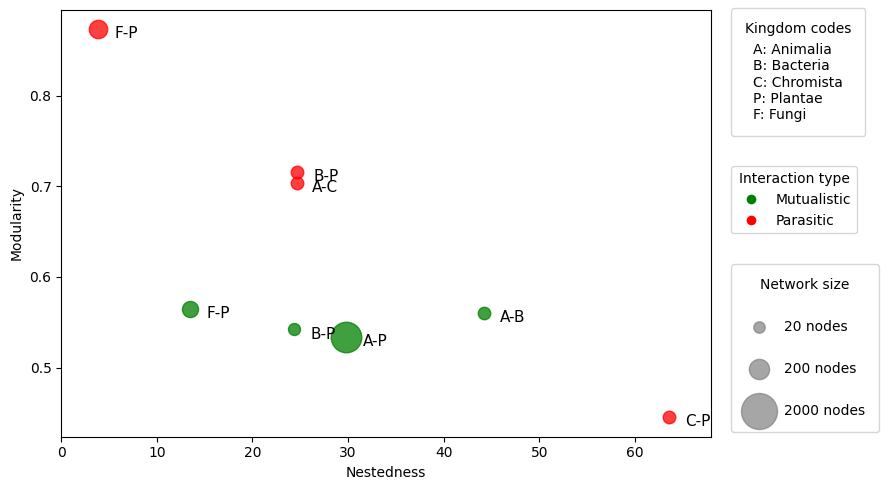

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

# ---------------------------------------------------
# Plot NODF vs Modularity with size & boxed legends
# ---------------------------------------------------
def plot_nodf_vs_modularity(subnetworks, min_nodes=20):

    letter_map = {
        "Animalia": "A",
        "Bacteria": "B",
        "Chromista": "C",
        "Protozoa": "C",
        "Plantae": "P",
        "Fungi": "F"
    }

    fig, ax = plt.subplots(figsize=(9, 5))

    size_scale = 15
    sizes_used = []

    # -----------------------------
    # Scatter points
    # -----------------------------
    for name, G in subnetworks.items():

        if G.number_of_nodes() <= min_nodes:
            continue
        if not (name.endswith("_m") or name.endswith("_p")):
            continue

        nodf = compute_nodf_bipartite(G)

        try:
            comms = greedy_modularity_communities(G)
            modularity = nx.algorithms.community.modularity(G, comms)
        except Exception:
            continue

        if np.isnan(nodf) or np.isnan(modularity):
            continue

        kingdoms = set(
            "Chromista" if G.nodes[n]["kingdom"] in ("Chromista", "Protozoa")
            else G.nodes[n]["kingdom"]
            for n in G.nodes
            if "kingdom" in G.nodes[n]
        )

        if len(kingdoms) != 2:
            continue

        letters = sorted(letter_map[k] for k in kingdoms)
        label = f"{letters[0]}-{letters[1]}"

        color = "green" if name.endswith("_m") else "red"
        size = size_scale * np.sqrt(G.number_of_nodes())
        sizes_used.append(G.number_of_nodes())

        ax.scatter(nodf, modularity, s=size, color=color, alpha=0.75)
        ax.text(nodf + 3, modularity - 0.01, label,
                fontsize=11, ha="center")

    ax.set_xlabel("Nestedness")
    ax.set_xlim(0, 68)
    ax.set_ylabel("Modularity")
    #ax.set_title("Nestedness vs Modularity")

    # =================================================
    # LEGEND 1 — Kingdom labels
    # =================================================
    kingdom_text = (
        "A: Animalia\n"
        "B: Bacteria\n"
        "C: Chromista\n"
        "P: Plantae\n"
        "F: Fungi"
    )

    leg1 = ax.legend(
        [Line2D([], [], linestyle="")],
        [kingdom_text],
        title="Kingdom codes",
        loc="upper left",
        bbox_to_anchor=(1.02, 1.02),
        frameon=True,
        handlelength=0,
        handletextpad=0,
        borderpad=1
    )
    ax.add_artist(leg1)

    # =================================================
    # LEGEND 2 — Interaction type (color)
    # =================================================
    color_handles = [
        Line2D([0], [0], marker="o", color="w",
               markerfacecolor="green", markersize=8,
               label="Mutualistic"),
        Line2D([0], [0], marker="o", color="w",
               markerfacecolor="red", markersize=8,
               label="Parasitic")
    ]

    leg2 = ax.legend(
        handles=color_handles,
        title="Interaction type",
        loc="upper left",
        bbox_to_anchor=(1.02, 0.65),
        frameon=True
    )
    ax.add_artist(leg2)

    # =================================================
    # LEGEND 3 — Network size (point size)
    # =================================================
    n_min = 20 #min(sizes_used)
    n_max = 2000 #max(sizes_used)
    n_mid = 200

    size_handles = [
        ax.scatter([], [], s=size_scale * np.sqrt(n_min),
                   color="gray", alpha=0.7,
                   label=f"{n_min} nodes"),
        ax.scatter([], [], s=size_scale * np.sqrt(n_mid),
                   color="gray", alpha=0.7,
                   label=f"{n_mid} nodes"),
        ax.scatter([], [], s=size_scale * np.sqrt(n_max),
                   color="gray", alpha=0.7,
                   label=f"{n_max} nodes")
    ]

    leg3 = ax.legend(
        handles=size_handles,
        title="Network size",
        loc="upper left",
        bbox_to_anchor=(1.02, 0.42),
        frameon=True,
        scatterpoints=1,
        labelspacing=2,
        borderpad=1
    )

    plt.tight_layout()
    plt.savefig('InterKingdom.png')
    plt.show()


# ---------------------------------------------------
# Run plot
# ---------------------------------------------------
plot_nodf_vs_modularity(subredes)


### Targeted and Random Node Removal

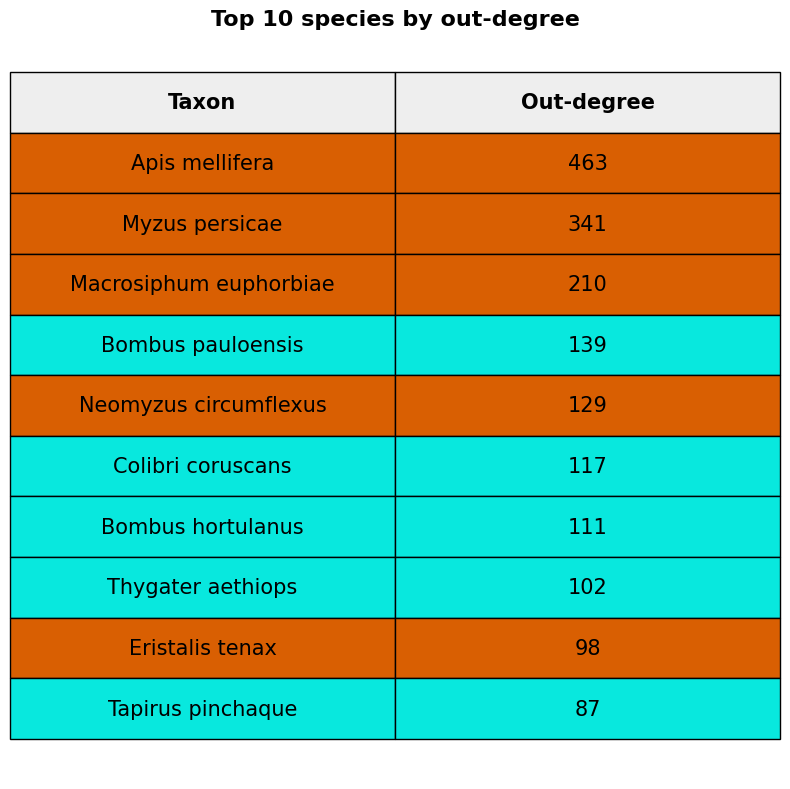

In [9]:
import networkx as nx
import matplotlib.pyplot as plt

def analyze_out_degree_table(G, top_n=10, title="Top species by out-degree"):
    """
    - Orders species by out-degree (descending)
    - Displays TOP N as a matplotlib table (figure)
    - Columns: Taxon | Out-degree
    - Row background color encodes Origin
    - Returns three ordered arrays:
        1) Global ordering
        2) Indigenous-first ordering
        3) Non-Indigenous-first ordering
    """

    # ---------------------------------------
    # Origin mapping & colors
    # ---------------------------------------
    origin_colors = {
        "i": "#08e8de",   # Indigenous
        "n": "#d95f02",   # Non-Indigenous
        None: "#d3d3d3"   # Unknown
    }

    # ---------------------------------------
    # Compute out-degree
    # ---------------------------------------
    if isinstance(G, nx.DiGraph):
        out_degrees = dict(G.out_degree())
    else:
        out_degrees = dict(G.degree())

    # ---------------------------------------
    # Global ordering
    # ---------------------------------------
    ordered_all = sorted(
        out_degrees.items(),
        key=lambda x: x[1],
        reverse=True
    )

    # ---------------------------------------
    # Prepare table data
    # ---------------------------------------
    table_data = []
    row_colors = []

    for node, k_out in ordered_all[:top_n]:
        origin = G.nodes[node].get("origin")
        table_data.append([node, k_out])
        row_colors.append(origin_colors.get(origin, "#d3d3d3"))

    # ---------------------------------------
    # Create table figure
    # ---------------------------------------
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.axis("off")

    table = ax.table(
        cellText=table_data,
        colLabels=["Taxon", "Out-degree"],
        loc="center",
        cellLoc="center"
    )

    table.auto_set_font_size(False)
    table.set_fontsize(15)
    table.scale(1, 3)

    # Header styling
    for col in range(2):
        cell = table[(0, col)]
        cell.set_facecolor("#eeeeee")
        cell.set_text_props(weight="bold", fontsize=15)

    # Row coloring by origin
    for i, color in enumerate(row_colors, start=1):
        for col in range(2):
            table[(i, col)].set_facecolor(color)

    ax.set_title(title, weight="bold", fontsize=16, pad=5)
    plt.tight_layout()
    plt.savefig('Top10OutDegree.png')
    plt.show()

    # ---------------------------------------
    # Indigenous-first ordering
    # ---------------------------------------
    indigenous_first = sorted(
        ordered_all,
        key=lambda x: (
            G.nodes[x[0]].get("origin") != "i",
            -x[1]
        )
    )

    # ---------------------------------------
    # Non-Indigenous-first ordering
    # ---------------------------------------
    non_indigenous_first = sorted(
        ordered_all,
        key=lambda x: (
            G.nodes[x[0]].get("origin") != "n",
            -x[1]
        )
    )

    return (
        [n for n, _ in ordered_all],
        [n for n, _ in indigenous_first],
        [n for n, _ in non_indigenous_first]
    )


# Example
ordered_all, indigenous_first, non_indigenous_first = analyze_out_degree_table(
    G_xx,
    top_n=10,
    title="Top 10 species by out-degree"
)


In [14]:
import numpy as np
import pandas as pd
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
from joblib import Parallel, delayed

# ---------------------------------------------------
# Remove isolates (secondary extinctions)
# ---------------------------------------------------
def remove_isolates_inplace(G):
    isolates = list(nx.isolates(G))
    if isolates:
        G.remove_nodes_from(isolates)


# ---------------------------------------------------
# Nestedness proxy (fast geometric proxy)
# ---------------------------------------------------
def compute_nestedness_proxy(G):
    try:
        mat = nx.to_numpy_array(G)
        if mat.size == 0:
            return np.nan

        mat = (mat > 0).astype(int)

        row_order = np.argsort(-mat.sum(axis=1))
        col_order = np.argsort(-mat.sum(axis=0))
        mat = mat[row_order][:, col_order]

        B = mat.sum()
        if B == 0:
            return np.nan

        filled = np.triu(mat, k=1).sum()
        return filled / B
    except:
        return np.nan


# ---------------------------------------------------
# Robustness proxy
# ---------------------------------------------------
def compute_robustness_proxy(G):
    try:
        Gu = G.to_undirected()
        if len(Gu) < 2:
            return np.nan

        clust = nx.average_clustering(Gu)
        avg_deg = np.mean([d for _, d in Gu.degree()]) / (len(Gu) - 1)
        giant = len(max(nx.connected_components(Gu), key=len)) / len(Gu)

        return 0.4 * clust + 0.3 * avg_deg + 0.3 * giant
    except:
        return np.nan


# ---------------------------------------------------
# Full metrics (computed after isolate removal)
# ---------------------------------------------------
def compute_metrics(G):
    out = {}
    out["Connectance"] = nx.density(G) if len(G) > 1 else np.nan

    try:
        Gu = G.to_undirected()
        comms = greedy_modularity_communities(Gu)
        out["Modularity"] = nx.algorithms.community.modularity(Gu, comms)
    except:
        out["Modularity"] = np.nan

    out["Nestedness"] = compute_nestedness_proxy(G)
    out["Robustness"] = compute_robustness_proxy(G)

    return out


# ---------------------------------------------------
# Random removal run (with cascades)
# ---------------------------------------------------
def random_removal_run(G, n_steps, nodes_per_step, total_nodes, seed):
    np.random.seed(seed)
    g = G.copy()
    nodes = list(g.nodes())
    np.random.shuffle(nodes)

    rows = []

    for step in range(n_steps):
        remove_isolates_inplace(g)

        metrics = compute_metrics(g)
        metrics["Fraction_remaining"] = len(g) / total_nodes
        rows.append(metrics)

        remove = nodes[step * nodes_per_step:(step + 1) * nodes_per_step]
        g.remove_nodes_from(remove)

    return pd.DataFrame(rows)


# ---------------------------------------------------
# Directed removal run (one strategy)
# ---------------------------------------------------
def directed_removal_run(G, order, n_steps, nodes_per_step, total_nodes, label):
    print(f"Running directed removal: {label}")
    g = G.copy()
    rows = []

    for step in range(n_steps):
        remove_isolates_inplace(g)

        metrics = compute_metrics(g)
        metrics["Fraction_remaining"] = len(g) / total_nodes
        rows.append(metrics)

        remove = order[step * nodes_per_step:(step + 1) * nodes_per_step]
        g.remove_nodes_from(remove)

    return label, pd.DataFrame(rows)


# ---------------------------------------------------
# Main progressive removal analysis
# ---------------------------------------------------
def progressive_removal_analysis(
    G,
    ordered_all,
    indigenous_first,
    non_indigenous_first,
    n_steps=10,
    n_reps_random=8,
    n_jobs=8
):
    total_nodes = len(G)
    nodes_per_step = max(1, total_nodes // n_steps)

    results = {}

    # -----------------------------
    # Random removals (parallel)
    # -----------------------------
    print(f"Running random removal with {n_jobs} threads...")
    random_dfs = Parallel(n_jobs=n_jobs, backend="loky")(
        delayed(random_removal_run)(
            G, n_steps, nodes_per_step, total_nodes, seed
        )
        for seed in range(n_reps_random)
    )

    df_random = pd.concat(random_dfs)
    df_random = (
        df_random
        .groupby("Fraction_remaining")
        .agg(["mean", "std"])
        .reset_index()
    )
    df_random.columns = [
        "_".join(col).strip("_") for col in df_random.columns
    ]

    results["random"] = df_random

    # -----------------------------
    # Directed removals (parallel by strategy)
    # -----------------------------
    print("Running directed removals in parallel...")
    directed_jobs = [
        ("ordered_all", ordered_all),
        ("indigenous_first", indigenous_first),
        ("non_indigenous_first", non_indigenous_first),
    ]

    directed_results = Parallel(
        n_jobs=min(3, n_jobs),
        backend="loky"
    )(
        delayed(directed_removal_run)(
            G, order, n_steps, nodes_per_step, total_nodes, label
        )
        for label, order in directed_jobs
    )

    for label, df in directed_results:
        results[label] = df

    return results


# ---------------------------------------------------
# Example call
# ---------------------------------------------------
results = progressive_removal_analysis(
    G_xx,
    ordered_all,
    indigenous_first,
    non_indigenous_first,
    n_steps=100,
    n_reps_random=16,
    n_jobs=12
)


Running random removal with 12 threads...
Running directed removals in parallel...


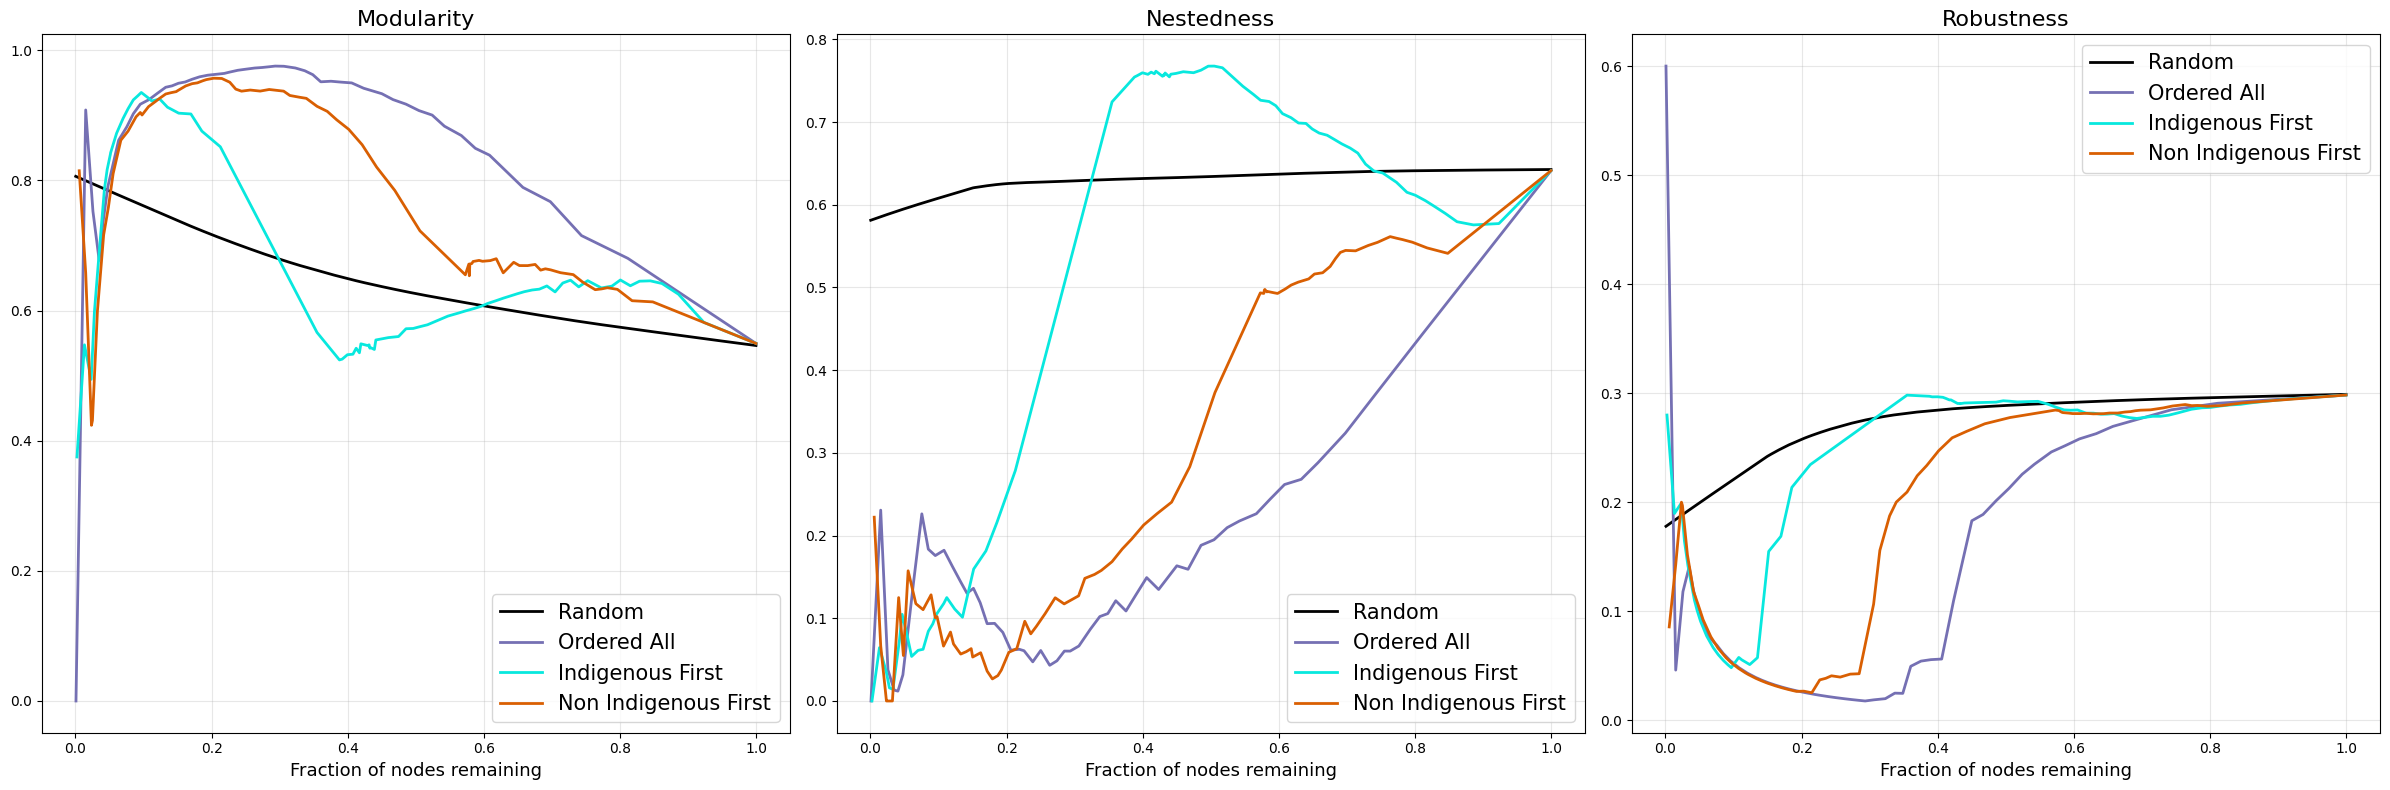

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess


def smooth_trend_with_band(x, y, frac=0.4):
    """
    LOWESS smoothing + global residual-based std band
    """
    order = np.argsort(x)
    x = np.array(x)[order]
    y = np.array(y)[order]

    smoothed = lowess(y, x, frac=frac, return_sorted=True)
    xs, ys = smoothed[:, 0], smoothed[:, 1]

    residuals = y - np.interp(x, xs, ys)
    std_local = np.std(residuals)

    return xs, ys, std_local


def graficar_resultados_suavizados(results):
    metricas = {
        "Modularity": "Modularity",
        "Nestedness": "Nestedness",
        "Robustness": "Robustness"
    }

    fig, axs = plt.subplots(1, 3, figsize=(24, 8), sharex=True)
    #fig.suptitle("Network response to node removal strategies", fontsize=16)

    df_random = results["random"]

    for ax, (metrica, label) in zip(axs, metricas.items()):

        # ==========================
        # RANDOM — smooth trend
        # ==========================
        x = df_random["Fraction_remaining"]
        y = df_random[f"{metrica}_mean"]

        xs, ys, std = smooth_trend_with_band(x, y)

        ax.plot(
            xs, ys,
            color="black",
            linewidth=2,
            label="Random"
        )

        ax.fill_between(
            xs,
            ys - std,
            ys + std,
            color="gray",
            alpha=0.3,
        )

        # ==========================
        # DIRECTED STRATEGIES
        # ==========================
        for key, color in zip(
            ["ordered_all", "indigenous_first", "non_indigenous_first"],
            ["#7570b3", "#08e8de", "#d95f02"]
        ):
            df = results[key]
            ax.plot(
                df["Fraction_remaining"],
                df[metrica],
                linestyle="-",
                color=color,
                linewidth=2,
                label=key.replace("_", " ").title()
            )

        ax.set_title(label, fontsize=16)
        ax.set_xlabel("Fraction of nodes remaining",fontsize=13)
        ax.grid(alpha=0.3)
        ax.legend(fontsize=15)

    plt.tight_layout()
    plt.savefig('NodeRemoval.png')
    plt.show()
graficar_resultados_suavizados(results)
